     |████████████████████████████████| 2.5 MB 6.5 MB/s eta 0:00:01
     |████████████████████████████████| 24.8 MB 52.5 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.1 which is incompatible.
autogluon-core 0.1.0 requires scikit-learn<0.25,>=0.22.0, but you have scikit-learn 1.0.2 which is incompatible.


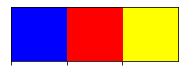

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as xp
import plotly.graph_objects as go
import numpy as np
from datetime import datetime
import missingno
import yaml
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,ShuffleSplit
from sklearn.manifold import TSNE
!pip install deep-forest

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

palette = ['blue',"red","yellow"]
sns.palplot(palette)

In [2]:
def split_to_onehot(df, col):
    """
    This method converts features separated by '|' into one-hot vectors.
    Additionally it drops unnecessary values, which present only in 
    test set / train set or have only one value.
    """
    # Getting all unique ganres values.
    unique = []
    for i in df.index:
        unique.extend(df.loc[i,col].split("|"))
    if "" in unique:
        unique.remove("")
    unique = list(set(unique))
    
    # Putting values into binary form 
    onehot = df.loc[:,["Category"]]
    onehot[unique] = np.zeros((len(unique),), dtype = np.int8)
    for i in df.index:
        g = set(df.loc[i,col].split("|"))
        for j in g:
            if j!="":
                onehot.loc[i,j] = 1
                
    # Dropping unnecessary values            
    _a = onehot.groupby("Category").sum()
    only_one = list(_a.sum()[_a.sum()==1].index)
    only_train = list(_a.loc["none"][_a.loc["none"]==0].index)
    only_test = list(_a.loc[["like",'dislike']].sum()[_a.loc[["like",'dislike']].sum()==0].index)
    _a = set(only_one + only_train + only_test)
    onehot = onehot.drop(_a, axis=1)
    
    return onehot

def onehot_to_tsne2(df, title):
    """
    This method converts one-hot representation into two tsne values.
    Such operation is needed to shrink the dimentionality of the dataset
    """
    onehot = df.drop("Category",axis=1)
    embedding = TSNE(n_components=2, init="pca")
    embedded = embedding.fit_transform(onehot)
    embedded = pd.DataFrame(embedded,columns=[f"{title}_tsne1",f"{title}_tsne2"])
    return embedded

def plot_commulative_onehot(onehot):
    """
    Method of plotting commulative values of the one hot feature representation
    """
    _df = onehot.groupby("Category").sum()
    fig = go.Figure()
    for i in range(len(_df.index)):
        k = _df.index[i]
        x,y=[],[]
        for g in _df.columns:
            if _df.loc[k,g]!=0:
                x.append(g)
                y.append(_df.loc[k,g])
        fig.add_trace(go.Bar(x=x, y=y,name=k,marker=dict(color=palette[i])))
    fig.show()

In [3]:
PATH = "../input/mymusicalprefrences/" 
train = pd.read_csv(f"{PATH}train.csv")
test = pd.read_csv(f"{PATH}test.csv")
description = yaml.load(open(f"{PATH}Description.yaml",'r'),Loader=yaml.FullLoader)
df = pd.concat([train,test]).reset_index(drop=True)
tr_mask = ~df.Category.isna()

In [4]:
df.columns = [i.strip() for i in df.columns]
print(set(df.columns))

{'BPM', 'Album', 'Artists', 'Id', 'Category', 'Dancebility', 'Duration', 'Key', 'Vocal', 'Labels', 'Energy', 'Release_year', 'Country', 'Happiness', 'Artists_Genres', 'Version', 'Track', 'Album_type'}


In [5]:
df.describe()

,Id,Category,Duration,Release_year,BPM,Energy,Dancebility,Happiness
count,965.000000,665.000000,965.000000,965.000000,965.000000,964.000000,964.000000,964.000000
mean,482.000000,0.527820,228246.466321,2011.816580,117.537824,68.751037,63.454357,50.268672
std,278.715805,0.499601,58343.816188,8.850096,25.801064,19.162589,16.420202,23.482333
min,0.000000,0.000000,102000.000000,1941.000000,49.000000,2.000000,15.000000,4.000000
25%,241.000000,0.000000,189760.000000,2008.000000,97.000000,56.000000,52.750000,32.000000
50%,482.000000,1.000000,222800.000000,2014.000000,117.000000,71.000000,65.000000,51.000000
75%,723.000000,1.000000,255200.000000,2018.000000,135.000000,83.000000,76.000000,68.000000
max,964.000000,1.000000,716490.000000,2021.000000,176.000000,100.000000,97.000000,99.000000


<AxesSubplot:>

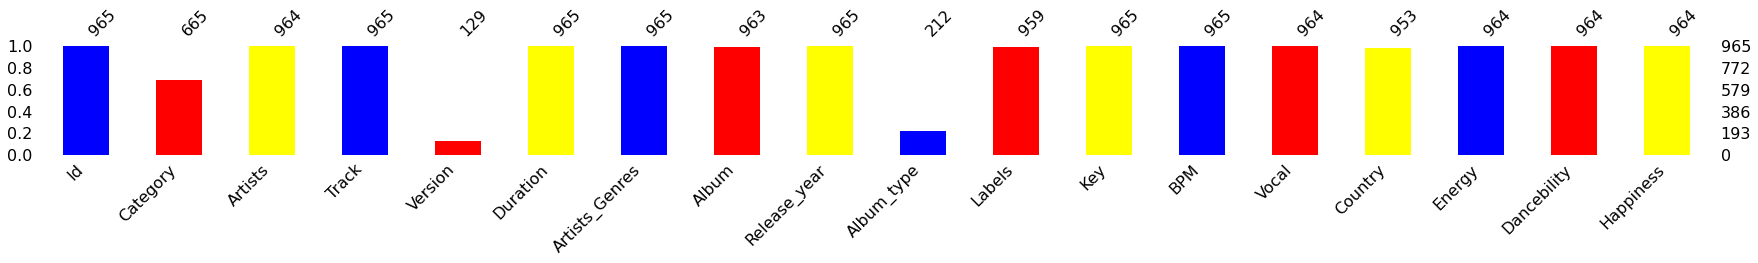

In [6]:
missingno.bar(df, color=palette, figsize=(30,2))

In [7]:
cat_features = {"Artists","Track","Version","Artists_Genres","Album","Album_type","Labels","Vocal","Country","Key"}
con_features = {"Duration","Release_year","BPM","Energy","Dancebility","Happiness"}
display(df[cat_features].head())
display(df[con_features].head())

,Album,Artists,Key,Vocal,Labels,Country,Artists_Genres,Version,Track,Album_type
0,Hail the Apocalypse,Avatar,F# Major,M,Gain,SWE,metal,NaN,Hail the Apocalypse,NaN
1,My Love Ultimate Essential Collection,Céline Dion,E Major,F,Sony Music Entertainment Canada,CA,soundtrack|classical|pop,Soundtrack,My Heart Will Go On,NaN
2,Skyfall,Adele,C Minor,F,Melted Stone|Skyfall|Columbia,GB,pop,Soundtrack,Skyfall,single
3,KISS Box Set,Kiss,E Major,M,The Island Def Jam,USA,hardrock|rock|foreignrap,Soundtrack,I Was Made for Lovin' You,NaN
4,Graduation,Kanye West,B♭ Minor,M,A Roc-A-Fella Records release,USA,foreignrap,NaN,Stronger,NaN


,BPM,Dancebility,Duration,Energy,Release_year,Happiness
0,93,42.0,253660,99.0,2014,30.0
1,99,43.0,284150,28.0,2019,4.0
2,76,35.0,286480,55.0,2012,8.0
3,128,77.0,268440,85.0,2001,87.0
4,104,62.0,311420,72.0,2007,49.0


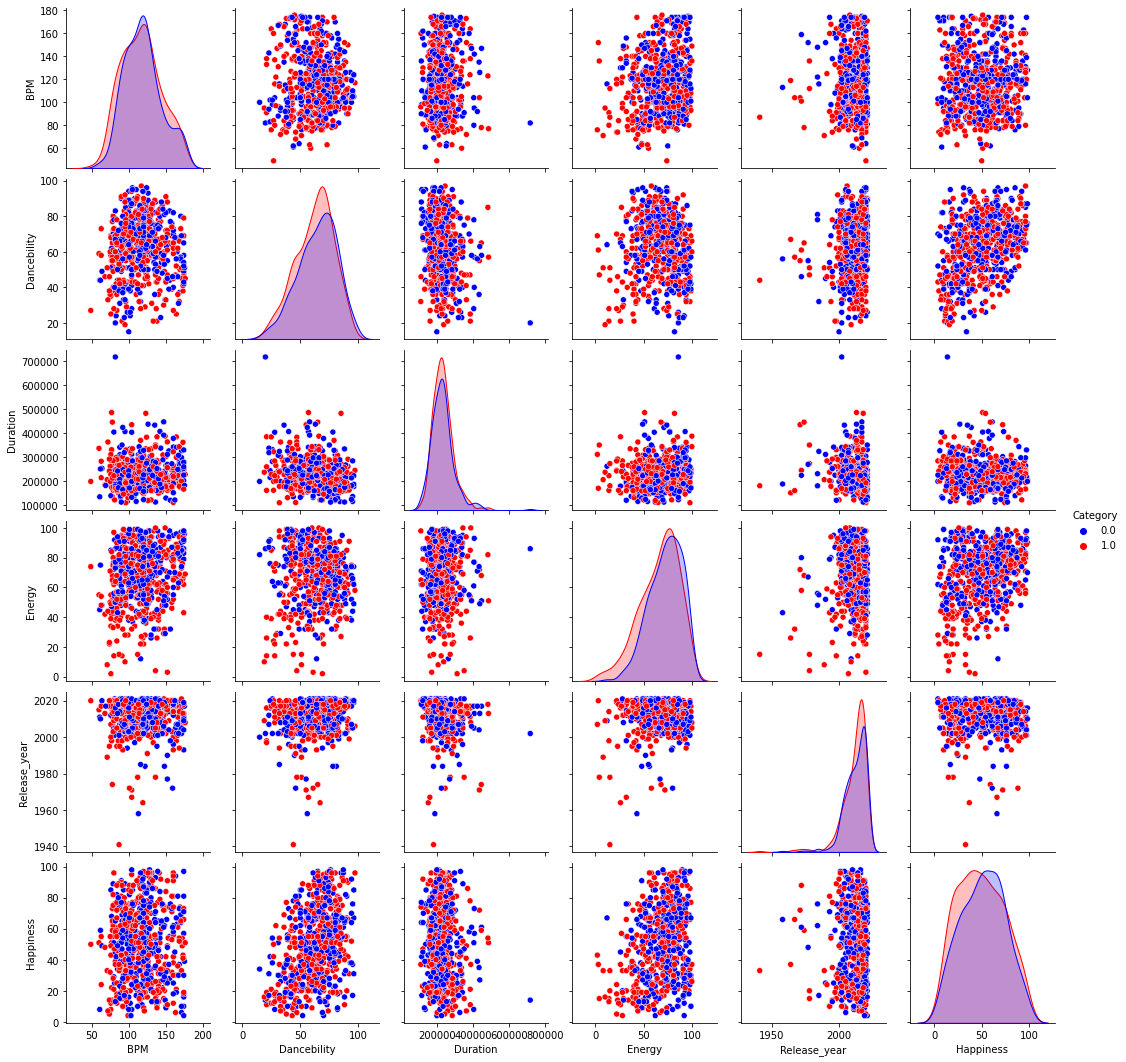

In [8]:
sns.pairplot(df[list(con_features)+["Category"]],palette=palette[:2], hue="Category")

In [9]:
df["Category"] = df["Category"].fillna("none").replace({0:"dislike",1:"like"})
df

,Id,Category,Artists,Track,Version,Duration,Artists_Genres,Album,Release_year,Album_type,Labels,Key,BPM,Vocal,Country,Energy,Dancebility,Happiness
0,0,dislike,Avatar,Hail the Apocalypse,NaN,253660,metal,Hail the Apocalypse,2014,NaN,Gain,F# Major,93,M,SWE,99.0,42.0,30.0
1,1,like,Céline Dion,My Heart Will Go On,Soundtrack,284150,soundtrack|classical|pop,My Love Ultimate Essential Collection,2019,NaN,Sony Music Entertainment Canada,E Major,99,F,CA,28.0,43.0,4.0
2,2,like,Adele,Skyfall,Soundtrack,286480,pop,Skyfall,2012,single,Melted Stone|Skyfall|Columbia,C Minor,76,F,GB,55.0,35.0,8.0
3,3,like,Kiss,I Was Made for Lovin' You,Soundtrack,268440,hardrock|rock|foreignrap,KISS Box Set,2001,NaN,The Island Def Jam,E Major,128,M,USA,85.0,77.0,87.0
4,4,dislike,Kanye West,Stronger,NaN,311420,foreignrap,Graduation,2007,NaN,A Roc-A-Fella Records release,B♭ Minor,104,M,USA,72.0,62.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,960,none,Ленинград,Кабриолет,NaN,161530,rusrock,Кабриолет,2019,single,ShnurOK / Первое музыкальное,G Minor,132,M,RUS,82.0,75.0,80.0
961,961,none,Gorillaz,Rock The House,Radio Edit,183640,indie,G-Sides,2002,NaN,Parlophone,D Major,172,M,GB,82.0,75.0,61.0
962,962,none,Guano Apes,Open Your Eyes,NaN,186520,rock|alternative,Planet Of The Apes - Best Of Guano Apes,2015,NaN,Gun,E Minor,112,F,USA,96.0,63.0,43.0
963,963,none,The Chainsmokers|Coldplay,Something Just Like This,NaN,247620,electronics|rock|dance,Memories...Do Not Open,2017,NaN,Disruptor|Columbia,B Minor,130,M,GB,63.0,62.0,45.0


In [10]:
description["Key"]

{'description': 'The group of pitches, or scale, that forms the basis of a music composition',
 'values': 'Contains from identifier of the tonic chord from A to G, # or ♭, Major or Minor triad'}

In [11]:
xp.scatter(df, x="Key", y="Track",color="Category", height=500, color_discrete_sequence=palette)

In [12]:
df["isMajor"], df["Key"] = df["Key"].apply(lambda x: x.split(" ")[1]), df["Key"].apply(lambda x: x.split(" ")[0])
df.loc[:,"Key"] = df["Key"].replace({"D♭": "C#", "E♭": "D#", "G♭": "F#", "A♭": "G#","B♭":"A#"})
xp.scatter(df, x="Key", y="Track",color="Category", height=500, color_discrete_sequence=palette)

In [13]:
df.loc[:,"isMajor"] = (df["isMajor"]=="Major").astype(int)
_df = df.groupby(["isMajor","Category"], as_index=False).count()
xp.bar(_df,x="isMajor", y="Track",color="Category", height=400, color_discrete_sequence=palette)

In [14]:
_df = df.copy(deep=True)
_df["Key_percise"] = _df["Key"] +"_major:"+ _df["isMajor"].astype(str)
_df = _df.groupby(["Key_percise","Category"], as_index=False).count()
xp.bar(_df, x="Key_percise", y="Track", color="Category", height=500, color_discrete_sequence=palette)

In [15]:
df[list(set(df["Key"].values))] = OneHotEncoder().fit_transform(df[["Key"]]).toarray()
df = df.drop("Key", axis=1)

In [16]:
description["Release year"]

{'description': 'The year of the albom release', 'values': 'Year number'}

In [17]:
xp.scatter(df, x="Release_year", y="Track",color="Category", height=500, color_discrete_sequence=palette)

In [18]:
# Lets create the decade feature, to detect some music of 80th, 90th etc. as a specific janre
df.loc[:,"Release_decade"] = (df.loc[:,"Release_year"]//10 * 10)
# Cause of the small number of values, we will put all <90th toone value, called 80th
df.loc[df.loc[:,"Release_decade"]<1990,"Release_decade"] = 1980 
_df = df.groupby(["Release_decade","Category"], as_index=False).count()
xp.bar(_df,x="Release_decade", y="Track",color="Category",height=500, color_discrete_sequence=palette)

In [19]:
description["Artists Genres"]

{'description': 'The list of ganres for the specified artist (not the current track)',
 'values': "Ganres labels separated by '|'"}

In [20]:
ganres_onehot = split_to_onehot(df, "Artists_Genres")
plot_commulative_onehot(ganres_onehot)

In [21]:
genres_embedded = onehot_to_tsne2(ganres_onehot, "Genres")
_df = genres_embedded.copy(deep=True)
_df[["Category","Artists_Genres"]] = df[["Category","Artists_Genres"]]
xp.scatter(_df,x="Genres_tsne1",y="Genres_tsne2",color="Category", hover_data=["Artists_Genres"], height=500, color_discrete_sequence=palette)

In [22]:
df = pd.concat([df,genres_embedded], axis=1)
df = df.drop("Artists_Genres", axis=1)

In [23]:
for k in ["Energy","Happiness","Dancebility","BPM"]:
    print(f"{k}:{description[k]}")

Energy:{'description': 'Continuouse value, describing energy of the track', 'values': '0-100'}
Happiness:{'description': 'Continuouse value, describing happiness of the track', 'values': '0-100'}
Dancebility:{'description': 'Continuouse value, describing dancebility of the track', 'values': '0-100'}
BPM:{'description': 'Beats-Per-Minute - the measure of tempo', 'values': 'integer value from 0 to inf'}


In [24]:
df["BPM"] = df["BPM"].apply(lambda x: str(x)[1:] if str(x)[0]=='`' else x)
df[['Energy', 'Happiness', 'Dancebility','BPM']] = df[['Energy', 'Happiness', 'Dancebility','BPM']].fillna(0)
df[['Energy%', 'Happiness%', 'Dancebility%']] = df[['Energy', 'Happiness', 'Dancebility']].apply(lambda x: x/sum(x), axis=1)
df[['Energy%', 'Happiness%', 'Dancebility%']] = df[['Energy%', 'Happiness%', 'Dancebility%']].fillna(0)

In [25]:
print(description["Labels"])

{'description': 'Record labels', 'values': "string value, separated with '|'"}


In [26]:
df.Labels = df.Labels.fillna('NA')
labels_onehot = split_to_onehot(df, "Labels")
plot_commulative_onehot(labels_onehot)

In [27]:
labels_embedded = onehot_to_tsne2(labels_onehot, "Labels")
_df = labels_embedded.copy(deep=True)
_df[["Category","Labels"]] = df[["Category","Labels"]]
xp.scatter(_df,x="Labels_tsne1",y="Labels_tsne2",color="Category", hover_data=["Labels"], height=500, color_discrete_sequence=palette)

In [28]:
df = pd.concat([df,labels_embedded[["Labels_tsne1","Labels_tsne2"]]], axis=1)
df = df.drop("Labels", axis=1)

In [29]:
print(description["Artists"])

{'description': 'Artists names', 'values': "String values, separated with '|'"}


In [30]:
df.Artists = df.Artists.fillna("NA")
allstars = []
for i in df.index:
    allstars.extend(df.loc[i, "Artists"].split("|"))
len(set(allstars))

533

In [31]:
threshold = 3
others = Counter(allstars)
others = [k for k in others if others[k]<=threshold]
len(others)

452

In [32]:
in_train, in_test = [], []
for i in df.loc[tr_mask].index:
    in_train.extend(df.loc[i, "Artists"].split("|"))
for i in df.loc[~tr_mask].index:
    in_test.extend(df.loc[i, "Artists"].split("|"))
    
only_test = set(in_test) - set(in_train)
only_train = set(in_train) - set(in_test)
display(len(only_test))
display(len(only_train))

133

294

In [33]:
allstars = list(set(allstars) - set(others) - only_test - only_train)
print(len(allstars))
others = set(others) | only_test | only_train
print(len(others))

72
461


In [34]:
res = []
def prune(x):
    vector = np.zeros(len(allstars)+1) #for others
    x = [i for i in x.split("|")]
    for i in range(len(allstars)):
        vector[i]=1 if allstars[i] in x else 0
    if len(x)>sum(vector):
        vector[-1]=1
    res.append(vector)

df["Artists"].apply(prune)
onehot_artists = pd.DataFrame(res, columns = allstars+["Others"], index=df.index)

In [35]:
onehot_artists

,Panic! At The Disco,Тимати,Rihanna,Young Thug,Christina Aguilera,Скриптонит,Eminem,Bob Marley,The White Stripes,Mac Miller,Maroon 5,Jay-Z,Queen,Travis Scott,Miley Cyrus,Post Malone,Ленинград,Arctic Monkeys,Pitbull,Егор Крид,MORGENSHTERN,Lil Pump,Lady Gaga,Lana Del Rey,Frank Sinatra,Shakira,Marilyn Manson,MONATIK,Tove Lo,MARUV,Beyoncé,FEDUK,Oxxxymiron,Gorillaz,Pink Floyd,Red Hot Chili Peppers,T-Fest,The Weeknd,MØ,Kings Of Leon,Green Day,"Tyler, The Creator",twenty one pilots,Kali Uchis,Drake,Sam Smith,Imagine Dragons,Little Big,Limp Bizkit,BLACKPINK,104,Coldplay,Justin Timberlake,Jennifer Lopez,Radiohead,The Prodigy,Dua Lipa,Markul,Billie Eilish,Rich The Kid,Anderson .Paak,Hippie Sabotage,Pharrell Williams,Britney Spears,OK Go,Иван Дорн,Элджей,Tom Waits,Kendrick Lamar,6ix9ine,Black Eyed Peas,Thomas Mraz,Others
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
df["Other_Artists"] = onehot_artists["Others"]
onehot_artists = onehot_artists.drop("Others", axis=1)
onehot_artists["Category"] = df["Category"]

In [37]:
plot_commulative_onehot(onehot_artists)

In [38]:
artists_embedded = onehot_to_tsne2(onehot_artists, "Artists")
_df = artists_embedded.copy(deep=True)
_df[["Category","Artists"]] = df[["Category","Artists"]]
xp.scatter(_df,x="Artists_tsne1",y="Artists_tsne2",color="Category", hover_data=["Artists"], height=500, color_discrete_sequence=palette)

In [39]:
df = pd.concat([df,artists_embedded[["Artists_tsne1","Artists_tsne2"]]], axis=1)
df = df.drop("Artists", axis=1)

In [40]:
for i in ["Track", "Version", "Album_type"]:
    print(description[i])

{'description': 'Track title', 'values': 'String value'}
{'description': 'Track version description', 'values': ['Radio Edit', 'Remaster', 'Remix', 'Single Edit', 'Soundtrack']}
{'description': 'Type of the albom', 'values': {'compilation': 'Compiltaion from different albums - means that this release is not the first version of the track', 'single': 'Single-track release'}}


In [41]:
artists_encoder = LabelEncoder()
df["Track"] = artists_encoder.fit_transform(df["Track"])

In [42]:
_df = df.groupby(["Version","Category"], as_index=False).count()
xp.bar(_df,x="Version",y="Id",color="Category", color_discrete_sequence=palette)

In [43]:
df["Version"] = df["Version"].fillna("NA")
versions = set(df["Version"])
df[list(versions)] = OneHotEncoder().fit_transform(df[["Version"]]).toarray()
df = df.drop(["Version","NA"], axis=1)

In [44]:
_df = df.groupby(["Album_type","Category"], as_index=False).count()
xp.bar(_df,x="Album_type",y="Id",color="Category", color_discrete_sequence=palette)

In [45]:
df["Album_type"] = df["Album_type"].fillna("NA")
versions = set(df["Album_type"])
df[list(versions)] = OneHotEncoder().fit_transform(df[["Album_type"]]).toarray()
df = df.drop(["Album_type","NA"], axis=1)

In [46]:
print(description["Album"])

{'description': 'Album title', 'values': 'String value'}


In [47]:
df["Album"] = df["Album"].fillna("NA")
ganres_onehot = split_to_onehot(df, "Album")
plot_commulative_onehot(ganres_onehot)

In [48]:
album_embedded = onehot_to_tsne2(onehot_artists, "Album")
_df = album_embedded.copy(deep=True)
_df[["Category","Album"]] = df[["Category","Album"]]
xp.scatter(_df,x="Album_tsne1",y="Album_tsne2",color="Category", hover_data=["Album"], height=500, color_discrete_sequence=palette)

In [49]:
df = pd.concat([df,album_embedded[["Album_tsne1","Album_tsne2"]]], axis=1)
df = df.drop("Album", axis=1)

In [50]:
print(description["Vocal"])

{'description': 'Types of the vocals in the track', 'values': "Values, separated with '|' (M - male, F- female, N - no vocal)"}


In [51]:
df["Vocal"] = df["Vocal"].fillna('N')
onehot = np.zeros((len(df),2))
for i in range(len(df)):
    v = df.iloc[i]["Vocal"]
    if v == 'F':
        onehot[i] = [1,0]
    elif v == 'M':
        onehot[i] = [0,1]
    elif v == 'F|M':
        onehot[i] = [1,1]
df[["Fem_voc","Mal_voc"]] = onehot
df = df.drop("Vocal",axis=1)

In [52]:
print(description["Country"])

{'description': 'Codes of countries of production', 'values': {'AT': 'Austria', 'AU': 'Australia', 'BEL': 'Belarus', 'BAR': 'Barbados', 'CA': 'Canada', 'COL': 'Colombia', 'DE': 'Germany', 'DK': 'Denmark', 'FIN': 'Finland', 'FR': 'France', 'IRL': 'Ireland', 'ITL': 'Italy', 'JM': 'Jamaica', 'KZ': 'Kazakhstan', 'KR': 'South Korea', False: 'Norway', 'NED': 'Netherlands', 'POR': 'Portugal', 'RUS': 'Russia', 'SWE': 'Sweden', 'UA': 'Ukraine', 'JP': 'Japan', 'TR': 'Trinidad', 'AZE': 'Azerbaijan', 'GB': 'Great Britain', 'NA': 'Not available', 'USA': 'USA'}}


In [53]:
df["Country"] = df["Country"].fillna("NA")
country_onehot = split_to_onehot(df, "Country")
plot_commulative_onehot(country_onehot)

In [54]:
country_onehot = country_onehot.drop("Category", axis=1)
df = pd.concat([df,country_onehot], axis=1)
df = df.drop("Country", axis=1)

In [55]:
df2=df.replace({"dislike":0,"like":1}).drop("Id", axis=1)
df2

,Category,Track,Duration,Release_year,BPM,Energy,Dancebility,Happiness,isMajor,D#,C,E,A#,F#,A,D,G,B,C#,F,G#,Release_decade,Genres_tsne1,Genres_tsne2,Energy%,Happiness%,Dancebility%,Labels_tsne1,Labels_tsne2,Other_Artists,Artists_tsne1,Artists_tsne2,Remix,Remaster,Radio Edit,Soundtrack,Single Edit,single,compilation,Album_tsne1,Album_tsne2,Fem_voc,Mal_voc,AU,CA,GB,DK,JM,SWE,UA,BAR,FR,KR,COL,NA,USA,RUS,KZ
0,0,269,253660,2014,93,99.0,42.0,30.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2010,-7.832385,-5.385359,0.578947,0.175439,0.245614,-120.986328,115.843384,1.0,-37.726673,-63.275421,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-69.817436,-31.162561,0.0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,468,284150,2019,99,28.0,43.0,4.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2010,13.759465,12.417393,0.373333,0.053333,0.573333,139.579803,26.410784,1.0,-9.170327,20.822311,0.0,0.0,0.0,0.0,1.0,1.0,0.0,16.981005,-4.877897,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,625,286480,2012,76,55.0,35.0,8.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,11.663954,17.296427,0.561224,0.081633,0.357143,-2.650672,222.817398,1.0,-37.726673,-63.275421,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-69.817436,-31.162561,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,342,268440,2001,128,85.0,77.0,87.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2000,-7.690830,12.588734,0.341365,0.349398,0.309237,66.627640,407.712006,1.0,-37.726673,-63.275421,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-69.817436,-31.162561,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,670,311420,2007,104,72.0,62.0,49.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000,20.386042,-13.654357,0.393443,0.267760,0.338798,65.778328,-76.841637,1.0,-37.726673,-63.275421,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-69.817436,-31.162561,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,none,876,161530,2019,132,82.0,75.0,80.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2010,-10.730289,-12.085740,0.345992,0.337553,0.316456,-374.746521,85.895493,0.0,-293.885132,63.113079,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-267.208282,-112.600471,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
961,none,575,183640,2002,172,82.0,75.0,61.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2000,-27.363565,-12.444451,0.376147,0.279817,0.344037,151.906067,-353.278595,0.0,-147.397186,396.028320,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-164.436905,383.162598,0.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
962,none,510,186520,2015,112,96.0,63.0,43.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2010,-12.902514,28.076315,0.475248,0.212871,0.311881,185.011505,181.347427,1.0,-37.726673,-63.275421,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-69.817436,-31.162561,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
963,none,642,247620,2017,130,63.0,62.0,45.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010,1.848467,-0.238825,0.370588,0.264706,0.364706,-16.750486,228.474594,1.0,-320.158691,-263.908142,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-259.890778,-325.025940,0.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
from sklearn.model_selection import train_test_split
y=df2.iloc[0:665,0]
x=df2.iloc[0:665,1:]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15)

y_train=y_train.astype(np.uint8)

y_test=y_test.astype(np.uint8)

X_train=X_train.astype(np.uint8)

X_test=X_test.astype(np.uint8)

deploy=df2[lambda df2: df2.columns[1:]].tail(300)
deploy=deploy.astype(float).astype(np.uint8)


In [57]:
y_train.values

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,

In [58]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train),columns = X_train.columns,index=X_train.index)
deploy = pd.DataFrame(data=scaler.transform(deploy),columns = deploy.columns,index=deploy.index)
X_test = pd.DataFrame(data=scaler.transform(X_test),columns = X_test.columns,index=X_test.index)

In [59]:
X_train.values

array([[0.49019608, 0.73809524, 0.96491228, ..., 0.        , 0.        ,
        0.        ],
       [0.1254902 , 0.88095238, 0.80701754, ..., 1.        , 0.        ,
        0.        ],
       [0.85098039, 0.03968254, 0.98245614, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.65490196, 0.23809524, 0.68421053, ..., 1.        , 0.        ,
        0.        ],
       [0.61960784, 0.49206349, 0.75438596, ..., 1.        , 0.        ,
        0.        ],
       [0.70588235, 0.9047619 , 0.78947368, ..., 0.        , 0.        ,
        0.        ]])